In [94]:
# import libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
# %matplotlib inline

from urllib.parse import urljoin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, cross_val_predict, train_test_split

IS_COLAB = 'google.colab' in sys.modules

# palabras a buscar en campo descripción
text_mining_keywords = ['cochera', 'sum', 'parrilla', 'pileta']

# url repositorio
github_repo_url = 'https://github.com/arielfaur/prediccion-precio-propiedades-fmap-2020/raw/master/'
base_data_url = github_repo_url if IS_COLAB else ''


def vectorize_descripcion(df: pd.DataFrame):
    
    # entrenamos el modelo para buscar las keywords
    vectorizer = CountVectorizer(binary=True, strip_accents='unicode')  
    vectorizer.fit(TEXT_MINING_KEYWORDS)

    # hot encoding de los resultados
    desc = vectorizer.transform(df['descripcion'])

    # crear dataframe con resultados
    df_desc = pd.DataFrame(data=desc.toarray(), columns=vectorizer.get_feature_names())
    return pd.concat([df.reset_index(drop=True), df_desc.reset_index(drop=True)], axis=1, sort=False)
    

def preprocessing(df: pd.DataFrame):
    # guardar los id
    ids = df['id']

    # remover observaciones barrio = Puerto Madero y dimensiones > 100 m2
    df.drop(df[(df.BARRIO=='puerto madero') | (df.sup_total > 100)].index, inplace=True)
    
    # explotar la columna descripción, buscar keywords
    df['descripcion'].fillna('', inplace=True)
    df = vectorize_descripcion(df)
    
    # eliminar columnas innecesarias del modelo
    df.drop(['id', 
        'pub_inicio', 
        'pub_fin', 
        'pub_creada', 
        'subbarrio', 
        'titulo', 
        'descripcion',
        'barrio', 
        'BARRIO', 
        'COMUNA', 
        'n_uni',
        'n_boliches', 
        'n_clinicas', 
        'n_hospitales', 
        'n_comisarias',
        'n_embajadas', 
        'n_subte_bocas', 
        'n_barrios_p', 
        'n_homicidios',
        'n_hurtos', 
        'n_hurtos_auto', 
        'n_robo', 
        'n_robo_vehi',
        'n_atm', 
        'n_bici',
        'n_bancos', 
        'n_hotel_Alta', 
        'n_hotel_Media', 
        'n_hotel_Baja',
        'n_gasolina', 
        'n_gastronomica'],axis=1, inplace=True)
    
    # df.rename(columns={'BARRIO':'barrio'}, inplace=True)

    return ids, df


def split_data(df: pd.DataFrame, test_size = 0.05):
    y = df['precio']
    X = df.drop(['precio'], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=5)
    return X_train, X_test, y_train, y_test


## Preprocesamiento de los features: imputación, estandarización, one-hot encoding
def make_transformer_pipeline():
    numeric_features = ['lat', 'lon', 'habitaciones', 'dormitorios', 'banios',
       'sup_total', 'sup_cubierta'].append(TEXT_MINING_KEYWORDS)
    numeric_transformer = make_pipeline( 
        SimpleImputer(missing_values = np.nan, strategy='mean'),
        StandardScaler(),
    )

    categorical_features = ['barrio']
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='missing'),
        #SimpleImputer(strategy="most_frequent"),
        #KNNImputer(n_neighbors=3, weights="uniform"),     # KNNImputer tarda una eternidad...
        OneHotEncoder(handle_unknown='ignore')
    )

    return make_column_transformer(
        (numeric_transformer, numeric_features),
        # (categorical_transformer, categorical_features)
    )    

def baseline_rfr_model_pipeline():
    transformer = make_transformer_pipeline()
    rfr = RandomForestRegressor(n_estimators=300, max_depth=28, random_state = 5)
    
    return make_pipeline(transformer, rfr)

def create_train_rfr_model():
    transformer = make_transformer_pipeline()

    model = Pipeline([
        ('preprocessing', transformer),
        ('model', TransformedTargetRegressor(RandomForestRegressor(random_state=5), transformer=StandardScaler()))
    ])
    return model

def create_train_svr_model():
    transformer = make_transformer_pipeline()
    svr = SVR(C=1)

    pipeline = make_pipeline(transformer, svr)
    model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

    return model    

def create_train_lr_model():
    transformer = make_transformer_pipeline()
    lr = LinearRegression()

    pipeline = make_pipeline(transformer, lr)
    model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

    return model    

def plot_test_predictions(y_test, y_pred):
    # # graficar predicciones contra datos actuales
    # plt.figure(figsize = (18,10))
    # plot_k = sns.scatterplot(y_test, y_pred)
    # plot_k.set(xlabel='Precio test', ylabel='Precio predicción')
    # # graficar la identidad
    # x_plot = np.linspace(0,np.max(y_test),1000)
    # y_plot = x_plot
    # plt.plot(x_plot, y_plot, color='r')

    fig, ax = plt.subplots(figsize = (18,10))
    ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Precio test')
    ax.set_ylabel('Precio predicción')
    plt.show()



In [2]:
df_precio_barrio = pd.read_csv(urljoin(base_data_url,'precio-venta-deptos.csv'))
df_precio_barrio

barrio   año  trimestre  precio_prom    ambientes    estado  \
0         AGRONOMIA  2010          1          NaN  2 ambientes     Usado   
1         AGRONOMIA  2010          2          NaN  2 ambientes     Usado   
2         AGRONOMIA  2010          3          NaN  2 ambientes     Usado   
3         AGRONOMIA  2010          4          NaN  2 ambientes     Usado   
4         AGRONOMIA  2011          1          NaN  2 ambientes     Usado   
...             ...   ...        ...          ...          ...       ...   
7291  VILLA URQUIZA  2018          2       3353.0  3 ambientes  A estrer   
7292  VILLA URQUIZA  2018          3       3329.0  3 ambientes  A estrer   
7293  VILLA URQUIZA  2018          4       3316.0  3 ambientes  A estrer   
7294  VILLA URQUIZA  2019          1       3424.0  3 ambientes  A estrer   
7295  VILLA URQUIZA  2019          2       3344.0  3 ambientes  A estrer   

      comuna  
0         15  
1         15  
2         15  
3         15  
4         15  
...      ...  
7291      12  
7292      12  
7293      12  
7294      12  
7295      12  

[7296 rows x 7 columns]

In [103]:
df_train = pd.read_csv(urljoin(base_data_url,'data_def.csv'), sep=';', decimal=',')
df_train

id  pub_inicio     pub_fin  pub_creada        lat        lon  \
0          1  2019-11-20  9999-12-31  2019-11-20 -34.606891 -58.409890   
1          3  2019-11-19  2020-02-22  2019-11-19 -34.604912 -58.417065   
2          4  2019-05-21  2019-07-03  2019-05-21 -34.600886 -58.431204   
3          5  2019-05-21  2020-05-22  2019-05-21 -34.628760 -58.453224   
4          6  2019-07-15  2020-02-13  2019-07-15 -34.572144 -58.480173   
...      ...         ...         ...         ...        ...        ...   
50433  53245  2019-04-26  2019-05-08  2019-04-26 -34.631057 -58.480524   
50434  53246  2019-05-31  9999-12-31  2019-05-31 -34.582000 -58.404344   
50435  53247  2019-05-19  2019-06-08  2019-05-19 -34.600746 -58.425297   
50436  53248  2019-10-08  2019-12-14  2019-10-08 -34.576985 -58.430230   
50437  53249  2019-08-30  9999-12-31  2019-08-30 -34.583755 -58.443697   

              barrio subbarrio  habitaciones  dormitorios  ...  n_robo  \
0            Almagro       NaN           3.0          NaN  ...    1604   
1            Almagro       NaN           3.0          1.0  ...     952   
2       Villa Crespo       NaN           3.0          2.0  ...     467   
3             Flores       NaN           4.0          3.0  ...     442   
4      Villa Urquiza       NaN           3.0          NaN  ...     209   
...              ...       ...           ...          ...  ...     ...   
50433       Floresta       NaN           2.0          1.0  ...     375   
50434        Palermo       NaN           3.0          NaN  ...     331   
50435        Almagro       NaN           3.0          2.0  ...     666   
50436        Palermo       NaN           4.0          3.0  ...     327   
50437        Palermo       NaN           1.0          NaN  ...     286   

       n_robo_vehi  n_atm n_bici n_bancos  n_hotel_Alta n_hotel_Media  \
0                4     16      0       11             0             0   
1                1     10      2        7             0             0   
2                6      4      1        3             0             0   
3                4     12      0       10             0             0   
4                0      0      1        0             0             0   
...            ...    ...    ...      ...           ...           ...   
50433            2      3      0        2             0             0   
50434            1     15      1        8             0             0   
50435            3      9      0        6             0             0   
50436            4      7      0        2             0             0   
50437            4      5      0        1             0             0   

       n_hotel_Baja  n_gasolina  n_gastronomica  
0                 0           4              13  
1                 0           2               1  
2                 0           0              20  
3                 0           2              10  
4                 0           1               2  
...             ...         ...             ...  
50433             0           2              10  
50434             0           3              33  
50435             0           1              19  
50436             0           1              37  
50437             0           2              23  

[50438 rows x 39 columns]

In [81]:
df_train.columns

Index(['id', 'pub_inicio', 'pub_fin', 'pub_creada', 'lat', 'lon', 'barrio',
       'subbarrio', 'habitaciones', 'dormitorios', 'banios', 'sup_total',
       'sup_cubierta', 'titulo', 'descripcion', 'precio', 'BARRIO', 'COMUNA',
       'n_uni', 'n_boliches', 'n_clinicas', 'n_hospitales', 'n_comisarias',
       'n_embajadas', 'n_subte_bocas', 'n_barrios_p', 'n_homicidios',
       'n_hurtos', 'n_hurtos_auto', 'n_robo', 'n_robo_vehi', 'n_atm', 'n_bici',
       'n_bancos', 'n_hotel_Alta', 'n_hotel_Media', 'n_hotel_Baja',
       'n_gasolina', 'n_gastronomica'],
      dtype='object')

In [37]:
# Outliers a eliminar
df_train[(df_train.BARRIO=='puerto madero') | (df_train.sup_total > 100)]

id  pub_inicio     pub_fin  pub_creada        lat        lon  \
0          1  2019-11-20  9999-12-31  2019-11-20 -34.606891 -58.409890   
3          5  2019-05-21  2020-05-22  2019-05-21 -34.628760 -58.453224   
13        15  2019-08-10  2019-09-14  2019-08-10 -34.619530 -58.406230   
17        19  2019-09-21  2019-12-23  2019-09-21 -34.611316 -58.373395   
26        28  2019-11-19  2019-12-23  2019-11-19 -34.592661 -58.392841   
...      ...         ...         ...         ...        ...        ...   
50421  53230  2019-09-01  2019-09-04  2019-09-01 -34.597230 -58.393576   
50423  53232  2019-11-22  2020-01-05  2019-11-22 -34.594830 -58.387375   
50429  53239  2019-05-07  9999-12-31  2019-05-07 -34.564856 -58.461292   
50434  53246  2019-05-31  9999-12-31  2019-05-31 -34.582000 -58.404344   
50436  53248  2019-10-08  2019-12-14  2019-10-08 -34.576985 -58.430230   

                     barrio subbarrio  habitaciones  dormitorios  ...  n_robo  \
0                   Almagro       NaN           3.0          NaN  ...    1604   
3                    Flores       NaN           4.0          3.0  ...     442   
13            San Cristobal       NaN           4.0          3.0  ...     445   
17     Centro / Microcentro       NaN           6.0          5.0  ...     551   
26                 Recoleta       NaN           6.0          3.0  ...     470   
...                     ...       ...           ...          ...  ...     ...   
50421          Barrio Norte       NaN           3.0          2.0  ...     696   
50423              Recoleta       NaN           2.0          NaN  ...     455   
50429              Belgrano       NaN           5.0          NaN  ...     385   
50434               Palermo       NaN           3.0          NaN  ...     331   
50436               Palermo       NaN           4.0          3.0  ...     327   

       n_robo_vehi  n_atm n_bici n_bancos  n_hotel_Alta n_hotel_Media  \
0                4     16      0       11             0             0   
3                4     12      0       10             0             0   
13              10      2      0        0             0             0   
17               3     45      2       17             0             1   
26               1     22      1       20             0             0   
...            ...    ...    ...      ...           ...           ...   
50421            2     25      1       15             0             0   
50423            1     21      0       15             0             1   
50429            2      5      1        5             0             0   
50434            1     15      1        8             0             0   
50436            4      7      0        2             0             0   

       n_hotel_Baja  n_gasolina  n_gastronomica  
0                 0           4              13  
3                 0           2              10  
13                0           3              10  
17                0           0              50  
26                0           0              77  
...             ...         ...             ...  
50421             2           1              85  
50423             0           0              67  
50429             0           0              11  
50434             0           3              33  
50436             0           1              37  

[9491 rows x 39 columns]

In [104]:
    # remover observaciones Puerto Madero
# df_train = df_train[df_train['BARRIO']!='puerto madero']

df_train['descripcion'].fillna('', inplace=True)

df_train.drop(df_train[(df_train.BARRIO=='puerto madero') | (df_train.sup_total > 100)].index, inplace=True)
df_train

id  pub_inicio     pub_fin  pub_creada        lat        lon  \
1          3  2019-11-19  2020-02-22  2019-11-19 -34.604912 -58.417065   
2          4  2019-05-21  2019-07-03  2019-05-21 -34.600886 -58.431204   
4          6  2019-07-15  2020-02-13  2019-07-15 -34.572144 -58.480173   
5          7  2019-08-31  2020-05-03  2019-08-31 -34.564477 -58.456214   
6          8  2019-06-28  2019-07-10  2019-06-28 -34.563209 -58.468897   
...      ...         ...         ...         ...        ...        ...   
50431  53241  2019-11-19  2020-05-14  2019-11-19 -34.592948 -58.384794   
50432  53242  2019-09-12  2019-09-13  2019-09-12 -34.619259 -58.389630   
50433  53245  2019-04-26  2019-05-08  2019-04-26 -34.631057 -58.480524   
50435  53247  2019-05-19  2019-06-08  2019-05-19 -34.600746 -58.425297   
50437  53249  2019-08-30  9999-12-31  2019-08-30 -34.583755 -58.443697   

              barrio subbarrio  habitaciones  dormitorios  ...  n_robo  \
1            Almagro       NaN           3.0          1.0  ...     952   
2       Villa Crespo       NaN           3.0          2.0  ...     467   
4      Villa Urquiza       NaN           3.0          NaN  ...     209   
5           Belgrano       NaN           1.0          1.0  ...     542   
6            Coghlan       NaN           2.0          1.0  ...     246   
...              ...       ...           ...          ...  ...     ...   
50431         Retiro       NaN           1.0          0.0  ...     363   
50432   Constitución       NaN           3.0          2.0  ...     628   
50433       Floresta       NaN           2.0          1.0  ...     375   
50435        Almagro       NaN           3.0          2.0  ...     666   
50437        Palermo       NaN           1.0          NaN  ...     286   

       n_robo_vehi  n_atm n_bici n_bancos  n_hotel_Alta n_hotel_Media  \
1                1     10      2        7             0             0   
2                6      4      1        3             0             0   
4                0      0      1        0             0             0   
5                0     22      1       21             0             0   
6                2      3      1        2             0             0   
...            ...    ...    ...      ...           ...           ...   
50431            0     29      1       20             0             2   
50432           10     10      0        7             0             0   
50433            2      3      0        2             0             0   
50435            3      9      0        6             0             0   
50437            4      5      0        1             0             0   

       n_hotel_Baja  n_gasolina  n_gastronomica  
1                 0           2               1  
2                 0           0              20  
4                 0           1               2  
5                 0           1              27  
6                 0           2               7  
...             ...         ...             ...  
50431             0           0              53  
50432             0           2              17  
50433             0           2              10  
50435             0           1              19  
50437             0           2              23  

[40947 rows x 39 columns]

In [105]:
ids, df_train = preprocessing(df_train)

In [115]:
df_train

lat        lon  habitaciones  dormitorios  banios  sup_total  \
1     -34.604912 -58.417065           3.0          1.0     2.0       72.0   
2     -34.600886 -58.431204           3.0          2.0     1.0       57.0   
4     -34.572144 -58.480173           3.0          NaN     2.0        NaN   
5     -34.564477 -58.456214           1.0          1.0     1.0       35.0   
6     -34.563209 -58.468897           2.0          1.0     1.0       49.0   
...          ...        ...           ...          ...     ...        ...   
50431 -34.592948 -58.384794           1.0          0.0     1.0        NaN   
50432 -34.619259 -58.389630           3.0          2.0     2.0       66.0   
50433 -34.631057 -58.480524           2.0          1.0     1.0       57.0   
50435 -34.600746 -58.425297           3.0          2.0     1.0       58.0   
50437 -34.583755 -58.443697           1.0          NaN     1.0       34.0   

       sup_cubierta                                        descripcion  \
1              63.0  Departamento en Venta, 3 AMBIENTES + COCHERA E...   
2              57.0  Xintel (GOP-GOP-8943) Venta de Departamento 3 ...   
4              60.0  Venta - Departamento - Argentina, Buenos Aires...   
5              31.0  DEPARTAMENTO MONOAMBIENTE,TOTALMENTE EQUIPADO ...   
6              45.0  Xintel (ZET-ZET-1397) Venta de Departamento 2 ...   
...             ...                                                ...   
50431           NaN  Venta de Departamento 1 AMBIENTE en Recoleta.\...   
50432          67.0  Corredor Responsable: Lucas Federico Delgado -...   
50433          53.0  Corredor Responsable: Uno Bienes Raices SRL - ...   
50435          58.0  Lindo 3 ambientes, primer piso por escalera, 5...   
50437          30.0  El Emprendimiento Arevalo Estudios consiste en...   

         precio  
1      144000.0  
2      145000.0  
4      237000.0  
5      148000.0  
6      130000.0  
...         ...  
50431  139784.0  
50432  111000.0  
50433   87000.0  
50435   88000.0  
50437  113504.0  

[40947 rows x 9 columns]

In [107]:
vectorizer = CountVectorizer(binary=True)  
vectorizer.fit(text_mining_keywords)

# hot encoding de los resultados
desc = vectorizer.transform(df_train['descripcion'])

df_desc = pd.DataFrame(data=desc.toarray(), columns=vectorizer.get_feature_names())
df_desc

cochera  parrilla  pileta  sum
0            1         0       0    0
1            0         0       0    0
2            0         0       0    0
3            0         0       0    1
4            0         0       0    0
...        ...       ...     ...  ...
40942        0         0       0    0
40943        0         0       0    0
40944        0         0       0    0
40945        0         0       0    0
40946        1         0       0    0

[40947 rows x 4 columns]

In [126]:
X=pd.concat([df_train.reset_index(drop=True), df_desc.reset_index(drop=True)], axis=1, sort=False)
X

lat        lon  habitaciones  dormitorios  banios  sup_total  \
0     -34.604912 -58.417065           3.0          1.0     2.0       72.0   
1     -34.600886 -58.431204           3.0          2.0     1.0       57.0   
2     -34.572144 -58.480173           3.0          NaN     2.0        NaN   
3     -34.564477 -58.456214           1.0          1.0     1.0       35.0   
4     -34.563209 -58.468897           2.0          1.0     1.0       49.0   
...          ...        ...           ...          ...     ...        ...   
40942 -34.592948 -58.384794           1.0          0.0     1.0        NaN   
40943 -34.619259 -58.389630           3.0          2.0     2.0       66.0   
40944 -34.631057 -58.480524           2.0          1.0     1.0       57.0   
40945 -34.600746 -58.425297           3.0          2.0     1.0       58.0   
40946 -34.583755 -58.443697           1.0          NaN     1.0       34.0   

       sup_cubierta                                        descripcion  \
0              63.0  Departamento en Venta, 3 AMBIENTES + COCHERA E...   
1              57.0  Xintel (GOP-GOP-8943) Venta de Departamento 3 ...   
2              60.0  Venta - Departamento - Argentina, Buenos Aires...   
3              31.0  DEPARTAMENTO MONOAMBIENTE,TOTALMENTE EQUIPADO ...   
4              45.0  Xintel (ZET-ZET-1397) Venta de Departamento 2 ...   
...             ...                                                ...   
40942           NaN  Venta de Departamento 1 AMBIENTE en Recoleta.\...   
40943          67.0  Corredor Responsable: Lucas Federico Delgado -...   
40944          53.0  Corredor Responsable: Uno Bienes Raices SRL - ...   
40945          58.0  Lindo 3 ambientes, primer piso por escalera, 5...   
40946          30.0  El Emprendimiento Arevalo Estudios consiste en...   

         precio  cochera  parrilla  pileta  sum  
0      144000.0        1         0       0    0  
1      145000.0        0         0       0    0  
2      237000.0        0         0       0    0  
3      148000.0        0         0       0    1  
4      130000.0        0         0       0    0  
...         ...      ...       ...     ...  ...  
40942  139784.0        0         0       0    0  
40943  111000.0        0         0       0    0  
40944   87000.0        0         0       0    0  
40945   88000.0        0         0       0    0  
40946  113504.0        1         0       0    0  

[40947 rows x 13 columns]

In [9]:
X_train, X_test, y_train, y_test = split_data(df_train)

# Grid search para encontrar los mejores parámetros Random Forest 

In [104]:


# Entrenar modelo RandomForestRegressor con búsqueda de hiperparámetros
tuned_parameters = {'model__regressor__n_estimators': [300], 
                    'model__regressor__max_depth': [30, 40],
                    'model__regressor__max_features': ['sqrt', 'log2'],
                    # 'model__regressor__max_samples': [10000, 25000],
                    'model__regressor__min_samples_leaf': [1, 2],
                    'model__regressor__min_samples_split': [2, 3]}
model_rfr = create_train_rfr_model()
model = GridSearchCV(model_rfr, tuned_parameters, n_jobs=2, scoring='neg_root_mean_squared_error', refit='neg_root_mean_squared_error', verbose=5)
model.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 10.5min
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed: 12.2min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                     

In [105]:
print("Mejores parámetros encontrados RandomForestRegressor:")
print()
print(model.best_params_)
print()
print("Scores:")
print(model.best_score_)

Mejores parámetros encontrados RandomForestRegressor:

{'model__regressor__max_depth': 40, 'model__regressor__max_features': 'sqrt', 'model__regressor__min_samples_leaf': 1, 'model__regressor__min_samples_split': 2, 'model__regressor__n_estimators': 300}

Scores:
-118607.78176797021


In [106]:
model_rfr.set_params(**model.best_params_)
model_rfr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                   

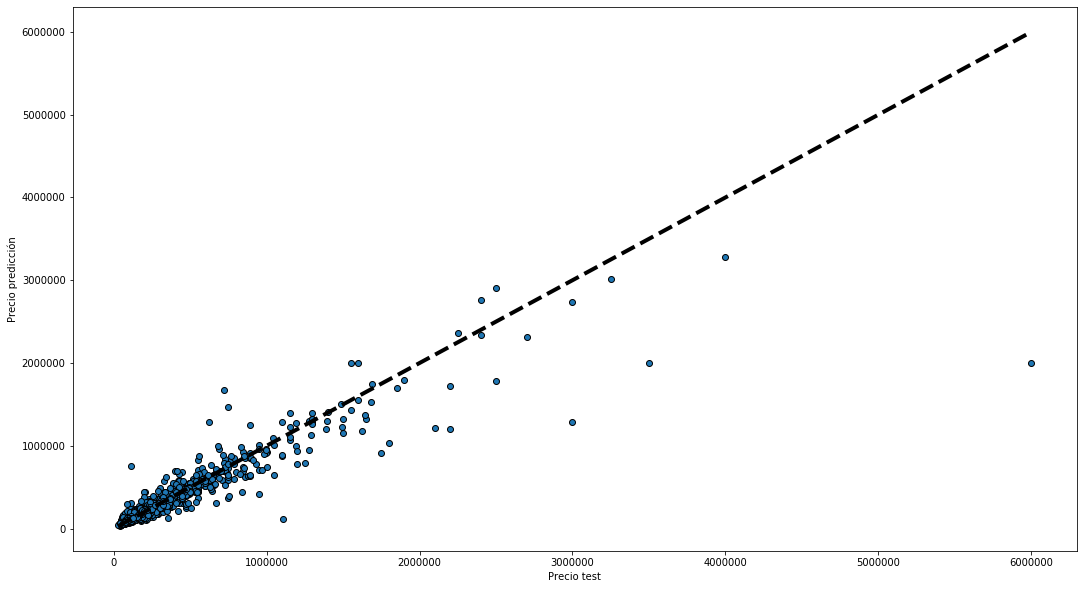

In [107]:
y_pred = model_rfr.predict(X_test)
plot_test_predictions(y_test, y_pred)

# Baseline Random Forest

In [10]:
model_rfr = baseline_rfr_model_pipeline()         # -118157.51541951629

In [11]:
scores = cross_val_score(model_rfr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
scores

array([-114130.38580416, -111954.21782714, -137498.15723521,
       -101741.45287422, -125463.36335685])

In [12]:
np.average(scores)

-118157.51541951629

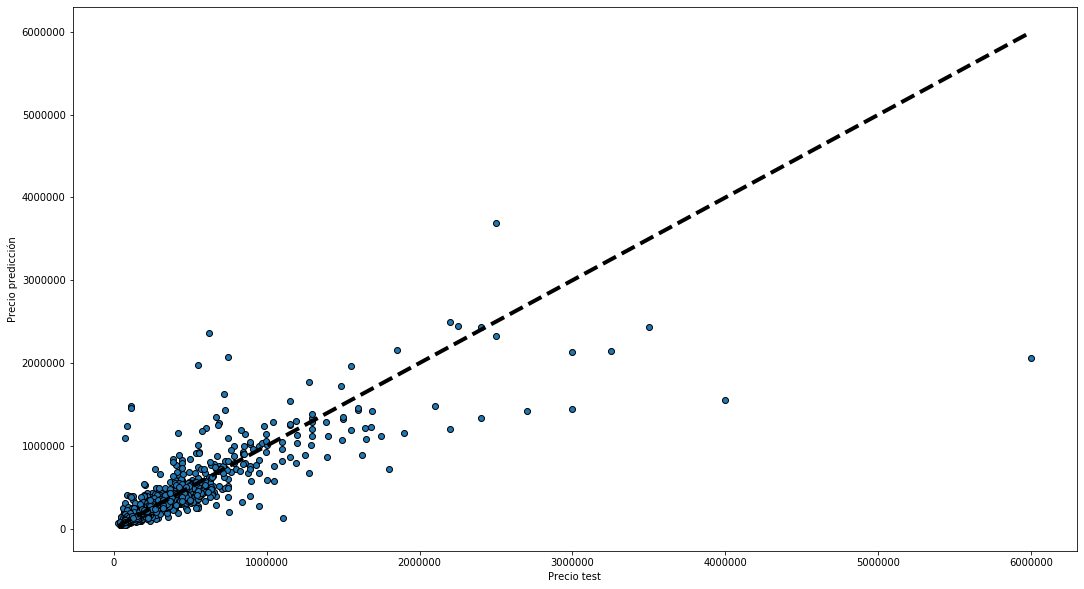

In [13]:
y_pred = cross_val_predict(model_rfr, X_test, y_test, cv=5)
plot_test_predictions(y_test, y_pred)

# Predicción en el set de test

In [17]:
df_test = pd.read_csv(urljoin(base_data_url,'data_test.csv'), sep=';', decimal=',')
df_test.head()

id  pub_inicio     pub_fin  pub_creada        lat        lon  \
0    2  2019-10-23  9999-12-31  2019-10-23 -34.586330 -58.508957   
1   34  2019-05-07  2019-06-23  2019-05-07 -34.581699 -58.433547   
2   54  2019-10-13  2019-12-23  2019-10-13 -34.628187 -58.429586   
3  101  2019-08-25  2019-09-14  2019-08-25 -34.593716 -58.440695   
4  103  2019-10-23  2019-11-09  2019-10-23 -34.591336 -58.447218   

         barrio          subbarrio  habitaciones  dormitorios  ...  n_robo  \
0  Villa Devoto                NaN           1.0          NaN  ...     130   
1       Palermo  Palermo Hollywood           1.0          1.0  ...     276   
2     Caballito                NaN           2.0          1.0  ...     333   
3       Palermo                NaN           2.0          1.0  ...     345   
4  Villa Crespo                NaN           2.0          1.0  ...     280   

   n_robo_vehi  n_atm n_bici n_bancos  n_hotel_Alta  n_hotel_Media  \
0            3      1      0        0             0              0   
1            2      6      1        0             0              0   
2           20      4      1        3             0              0   
3            1      4      0        3             0              0   
4            0      4      1        0             0              0   

   n_hotel_Baja  n_gasolina  n_gastronomica  
0             0           0               1  
1             0           3              78  
2             0           2              21  
3             0           1               7  
4             0           2               4  

[5 rows x 37 columns]

In [18]:
ids, df_test = preprocessing(df_test)

In [20]:
df_test.drop(['precio'], axis=1, inplace=True)
df_test.head()

lat        lon  habitaciones  dormitorios  banios  sup_total  \
0 -34.586330 -58.508957           1.0          NaN     NaN         45   
1 -34.581699 -58.433547           1.0          1.0     1.0         53   
2 -34.628187 -58.429586           2.0          1.0     1.0         42   
3 -34.593716 -58.440695           2.0          1.0     1.0         62   
4 -34.591336 -58.447218           2.0          1.0     1.0         44   

   sup_cubierta  cochera  sum  parrilla  pileta  
0            37        0    0         0       0  
1            40        1    0         0       0  
2            38        0    1         0       0  
3            38        0    0         0       0  
4            40        1    0         0       0

In [22]:
model_rfr.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                               

In [23]:
predicted = model_rfr.predict(df_test)
data = pd.DataFrame(data={'id' : ids.values, 'precio': np.round(predicted).astype(int) })

In [24]:
data


id  precio
0         2  111887
1        34  218239
2        54  131105
3       101  131573
4       103  120595
...     ...     ...
2495  53190  128007
2496  53221  296128
2497  53233  108902
2498  53243  133908
2499  53244  141347

[2500 rows x 2 columns]

In [25]:
data.to_csv('propiedades_prediccion.csv', index=False)
if IS_COLAB:
    from google.colab import files
    files.download('propiedades_prediccion.csv')